In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from scipy.stats import loguniform

In [2]:
sns.set_context('notebook')
sns.set_style('white')

### Defining Helper Functions

Below, we define helper functions to simplify your code later on:


In [3]:
def plot_explained_variance(pca):
    # This function graphs the accumulated explained variance ratio for a fitted PCA object.
    acc = [*accumulate(pca.explained_variance_ratio_)]
    fig, ax = plt.subplots(1, figsize=(50, 20))
    ax.stackplot(range(pca.n_components_), acc)
    ax.scatter(range(pca.n_components_), acc, color='black')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, pca.n_components_-1)
    ax.tick_params(axis='both', labelsize=36)
    ax.set_xlabel('N Components', fontsize=48)
    ax.set_ylabel('Accumulated explained variance', fontsize=48)
    plt.tight_layout()
    plt.show()

## Background

Before we begin using **PCA**, we should first understand:

1.  What PCA does
2.  How PCA Works


### What does PCA do?

*   Reduces the dimensionality of data. By reducing data dimensionality, PCA can also help with visualization.
*   May reduce noise in the process

\-Can be used to pre-process data improving the result of your algorithm


In [5]:
hwdf = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/HeightsWeights.csv', index_col=0)
hwdf.head()

,Height(Inches),Weight(Pounds),Weight(Kilograms)
Index,,,
1,65.78331,112.9925,51.253062
2,71.51521,136.4873,61.910233
3,69.39874,153.0269,69.412546
4,68.21660,142.3354,64.562914
5,67.78781,144.2971,65.452735


In [6]:
hwdf.to_csv("HeightsWeights.csv", index=False)

### Scaling data

**You should (almost) always scale your data before applying PCA**

**Why?**: There are many reasons, here are some:

*   Scaling your features make the features have the same standard deviation => same weight.

*   If the features have the same weight, PCA is able to best find the most significant components (principal components) without being biased towards features with high variance.

*   Computers do not do well in adding large numbers and small numbers, so, if all data is in the same range  algorithms usually perform better.

Let's use the `StandardScaler` from `sklearn.preprocessing`:


In [7]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
hwdf[:] = scaler.fit_transform(hwdf[:])
hwdf.columns = [f'{c} (scaled)' for c in hwdf.columns]
hwdf.head()

,Height(Inches) (scaled),Weight(Pounds) (scaled),Weight(Kilograms) (scaled)
Index,,,
1,-1.162051,-1.208072,-1.208072
2,1.852136,0.806805,0.806805
3,0.739165,2.225214,2.225214
4,0.117523,1.308328,1.308328
5,-0.107961,1.476561,1.476561


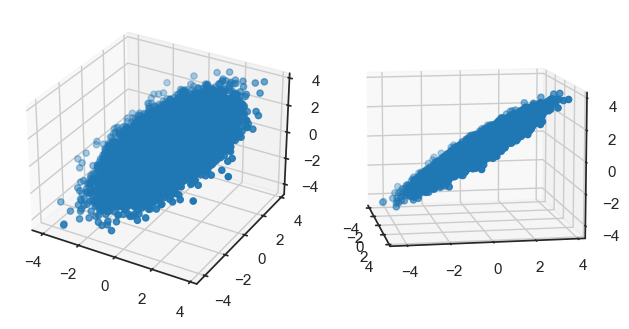

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
xs, ys, zs = [hwdf[attr] for attr in hwdf.columns]
ax1.scatter(xs, ys, zs)

ax2 = fig.add_subplot(122, projection='3d')
xs, ys, zs = [hwdf[attr] for attr in hwdf.columns]
ax2.view_init(elev=10, azim=-10)
ax2.scatter(xs, ys, zs)

plt.tight_layout()
plt.show()

As you can see, our data here forms a plane.

This is because the *weight in kilograms does not provide any more information than weight in pounds* (or vice-versa).

This becomes clear with the following, alternate perspective, showing the 2d relationships between the pairs of data and calculating the correlation  :


C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


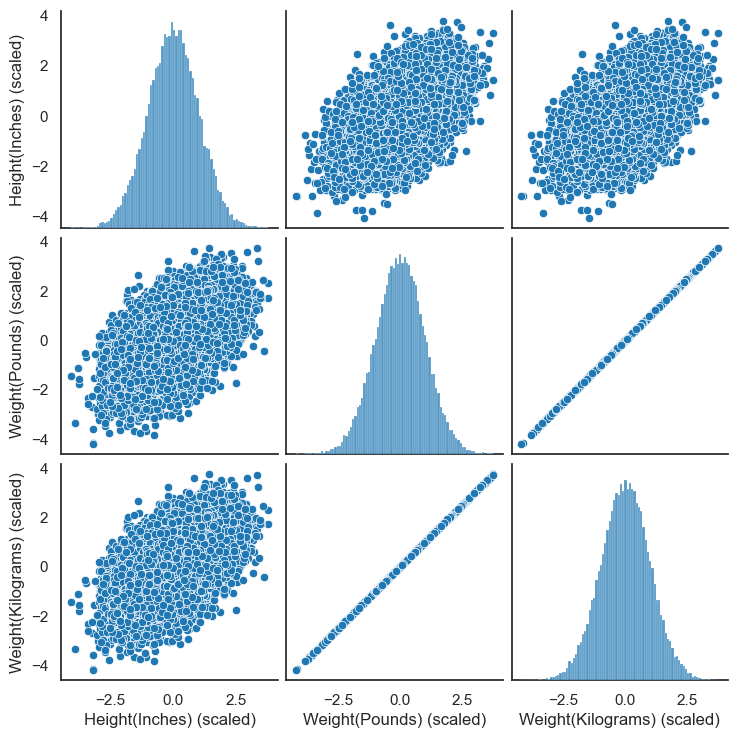

In [12]:
sns.pairplot(hwdf)
plt.show()

In [13]:
hwdf.corr().style.background_gradient(cmap='coolwarm')

,Height(Inches) (scaled),Weight(Pounds) (scaled),Weight(Kilograms) (scaled)
Height(Inches) (scaled),1.000000,0.502859,0.502859
Weight(Pounds) (scaled),0.502859,1.000000,1.000000
Weight(Kilograms) (scaled),0.502859,1.000000,1.000000


We see the weights are perfectly correlated, which means **Weight(Pounds)** tells us everything we need to know about **Weight(Kilograms)** ,thus we have clearly **redundant** data! Although, this example is exaggerated, it'll help demonstrate where PCA shines.

<b>Note</b> Standardizing your data before applying PCA is called *whitening*.

### Applying PCA

It's time to apply PCA, let's first apply PCA keeping the same dimension as the original data, i.e.: `n_components=3`.


In [15]:
pca = PCA().fit(hwdf)

In [16]:
xhat = pca.transform(hwdf)
xhat.shape

(25000, 3)

In [18]:
hwdf_PCA = pd.DataFrame(columns=[f'Projection on Component {i+1}' for i in range(len(hwdf.columns))], data=xhat)
hwdf_PCA.head()

,Projection on Component 1,Projection on Component 2,Projection on Component 3
0,2.051774,-0.243847,-1.443290e-15
1,-1.866218,1.117813,-3.330669e-16
2,-3.133436,-0.794420,4.440892e-16
3,-1.696186,-0.748473,8.881784e-16
4,-1.803402,-1.058234,8.881784e-16


**Why** are the values in the third column all essentially zero?

Let's look at the principle components:


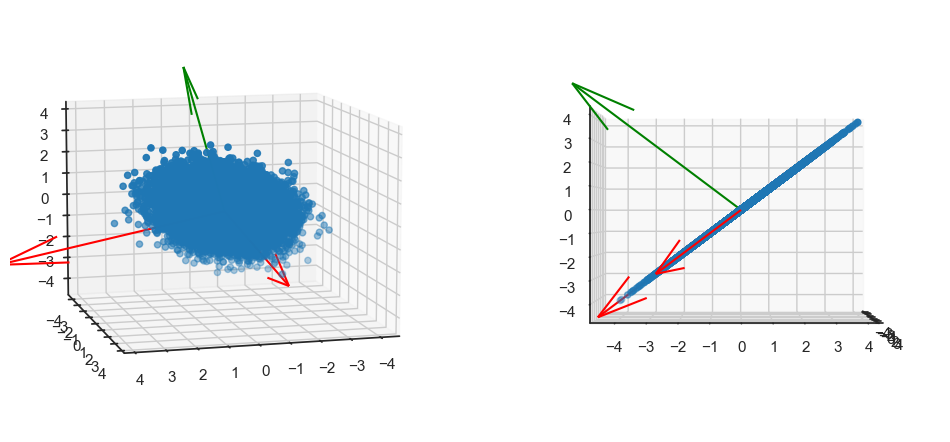

red component accounts for 78.98% of explained variance
red component accounts for 21.02% of explained variance
green component accounts for 0.00% of explained variance


In [19]:
colors = ['red', 'red', 'green']

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121, projection='3d')
xs, ys, zs = [hwdf[attr] for attr in hwdf.columns]
ax1.view_init(elev=10, azim=75)
ax1.scatter(xs, ys, zs)

for component, color in zip(pca.components_, colors):
    ax1.quiver(*[0, 0, 0], *(8 * component), color=color)

    
ax2 = fig.add_subplot(122, projection='3d')
xs, ys, zs = [hwdf[attr] for attr in hwdf.columns]
ax2.view_init(elev=0, azim=0)
ax2.scatter(xs, ys, zs)

for component, color in zip(pca.components_, colors):
    ax2.quiver(*[0, 0, 0], *(8 * component), color=color)

plt.show()

for color, ev in zip(colors, pca.explained_variance_ratio_):
    print(f'{color} component accounts for {ev * 100:.2f}% of explained variance')

The 3 colored arrows represent the directions of maximum variance in the original data `hwdf`. The new dataset `Xhat` is the projection of `hwdf` onto each principal component.

Most of the original data seems parallel to the red principle components meaning they are the two most dominant directions of variance of `hwdf`. The  green component is perpendicular to the data, as a result the projection is small.


C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Muhammad Umer Khan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


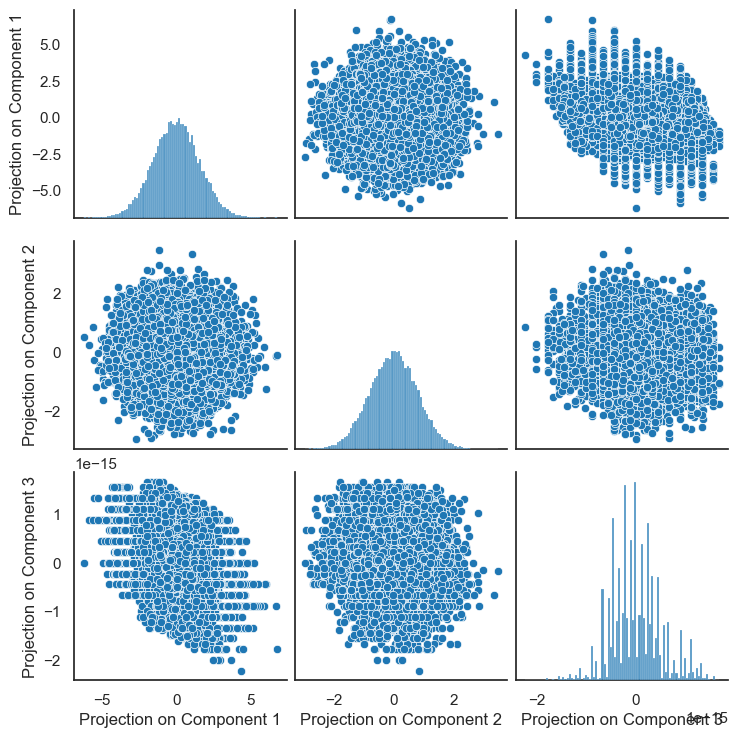

In [20]:
sns.pairplot(hwdf_PCA)
plt.show()

In [21]:
hwdf_PCA.corr().style.background_gradient(cmap='coolwarm')

,Projection on Component 1,Projection on Component 2,Projection on Component 3
Projection on Component 1,1.000000,0.000000,-0.401886
Projection on Component 2,0.000000,1.000000,-0.110685
Projection on Component 3,-0.401886,-0.110685,1.000000


As you can see, the correlations of the 3 principal components are now zero, meaning we have successfully de-correlated `hwdf` and obtained features that are linearly independent of each other.

Each component provides variance/information on a different direction. As we saw before that, the third component had a small projection, which means it doesn't provide much information about our original data `hwdf` in the new feature space.

Thus, we can remove the third dimension, while still keeping the vast majority of our data's information:


In [22]:
hwdf_PCA.drop('Projection on Component 3', axis=1, inplace=True)
hwdf_PCA.head()

,Projection on Component 1,Projection on Component 2
0,2.051774,-0.243847
1,-1.866218,1.117813
2,-3.133436,-0.794420
3,-1.696186,-0.748473
4,-1.803402,-1.058234


Now that you have some intuition behind PCA, let's start from the beginning and understand the PCA-pipeline.

In **sklearn.decomposition.PCA**, there is a parameter called `whiten` which helps standardize your input data if you set `whiten = True`. You could also use `StandardScaler()` as a separate step before using PCA.


In [23]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(hwdf), index=hwdf.index, columns=hwdf.columns)
X.head()

pca = PCA()
X_PCA = pd.DataFrame(pca.fit_transform(X), index=X.index, columns=[f'Component {i}' for i in range(pca.n_components_)])
# (Remember it's technically "Projection onto Component {i}")
X_PCA.head()

,Component 0,Component 1,Component 2
Index,,,
1,2.051774,-0.243847,1.185930e-14
2,-1.866218,1.117813,1.667633e-15
3,-3.133436,-0.794420,-7.946158e-17
4,-1.696186,-0.748473,6.028048e-16
5,-1.803402,-1.058234,4.588560e-16


By default, `sklearn.decomposition.PCA` sorts the components by their explained variance.

Let's analyze the explained variance ratios:


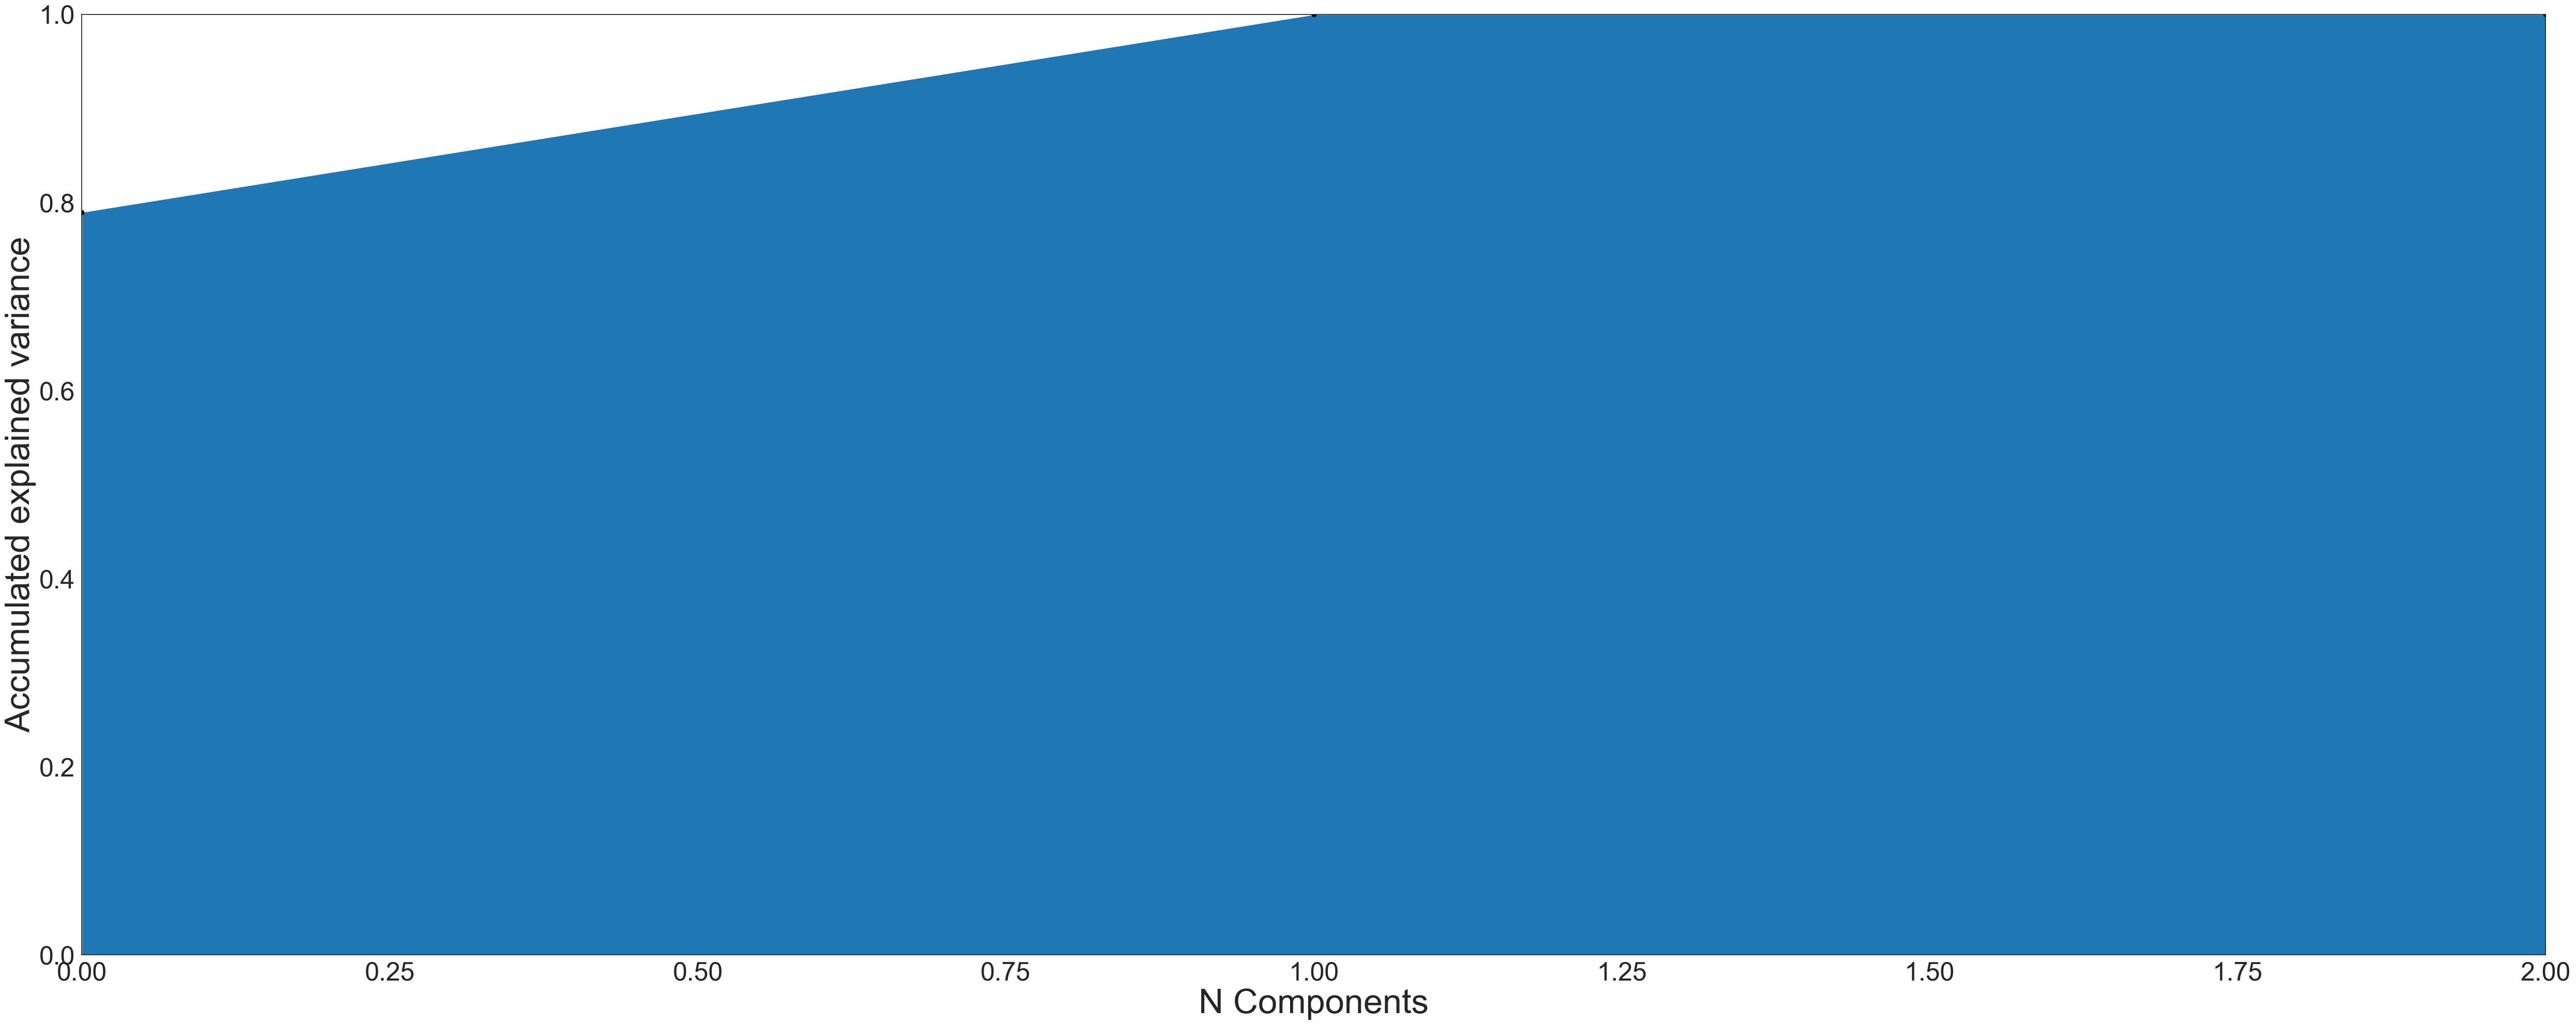

In [24]:
plot_explained_variance(pca)

In [25]:
threshold = 0.99
num = next(i for i, x in enumerate(accumulate(pca.explained_variance_ratio_), 1) if x >= threshold)
print(f'We can keep the first {num} components and discard the other {pca.n_components_-num},')
print(f'keeping >={100 * threshold}% of the explained variance!')

We can keep the first 2 components and discard the other 1,
keeping >=99.0% of the explained variance!


In [26]:
X_PCA.drop([f'Component {i}' for i in range(num, pca.n_components_)], axis=1, inplace=True)
X_PCA.head()

,Component 0,Component 1
Index,,
1,2.051774,-0.243847
2,-1.866218,1.117813
3,-3.133436,-0.794420
4,-1.696186,-0.748473
5,-1.803402,-1.058234


## Using PCA to Improve Facial Recognition

PCA is commonly used for Facial Recognition.

In this example, we will apply a method called "**Eigenfaces**"

The idea of *eigenfaces* is:

1.  You have images of faces of dimension $a \times b$ pixels.
2.  You "roll" these out into vectors of size $a \cdot n$.
3.  You apply PCA to the vectors.
4.  You determine how many principal components you want to train under; let's call this $C$.
5.  You train on the original image-vectors of size $a \cdot b$ projected onto your $C$ components, reshaped back to $a \times b$ bitmaps.


In [27]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

ContentTooShortError: <urlopen error retrieval incomplete: got only 144228701 out of 243346528 bytes>

In [ ]:
N, h, w = lfw_people.images.shape
target_names = lfw_people.target_names

In [ ]:
y = lfw_people.target
X = lfw_people.data
n_features = X.shape[1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [ ]:
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1)
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
hmap = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    xticklabels=lfw_people.target_names,
    yticklabels=lfw_people.target_names,
    fmt='g'
)
hmap.set_xlabel('Predicted Value')
hmap.set_ylabel('Truth Value')

In [ ]:
pca = PCA(svd_solver='full',  whiten=True).fit(X_train)

In [ ]:
person_index=1

In [ ]:
Xhat=pca.transform(X[person_index,:].reshape(1, -1))

In [ ]:
plt.imshow(pca.inverse_transform(Xhat).reshape(h, w), cmap='gray')
plt.title("Image after PCA and inverse transform"  ) 
plt.show()
plt.imshow(lfw_people.images[person_index],cmap='gray')
plt.title("Image")
plt.show()

In [ ]:
plot_explained_variance(pca)
plt.show()

It looks like 150 components explain over 95% of the variance, usually 80% will do, let’s try and visualize some components.

<p>
<b>Note:</b> you can use Cross-validation to select the number of components  
</p>


In [ ]:
threshold = 0.60

In [ ]:
components = np.cumsum(pca.explained_variance_ratio_) < threshold
components.sum()

In [ ]:
for component in pca.components_[components,:]:
    plt.imshow(component.reshape(h, w),cmap='gray')
    plt.show()

In [ ]:
pca = PCA(n_components=150, svd_solver="randomized", whiten=True).fit(X_train)

In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
person_index = 1

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(lfw_people.images[person_index,:,:],cmap='gray')
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(pca.inverse_transform(pca.transform(X[person_index ,:].reshape(1, -1))).reshape(h, w),cmap='gray')
plt.title("PCA transformed and inverse-transformed image ") 

plt.tight_layout()
plt.show()

In [ ]:
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)

clf = clf.fit(X_train_pca, y_train)

In [ ]:
y_pred = clf.predict(X_test_pca)

In [ ]:
hmap = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    xticklabels=lfw_people.target_names,
    yticklabels=lfw_people.target_names,
    fmt='g'
)
hmap.set_xlabel('Predicted Value')
hmap.set_ylabel('Truth Value')

# Exercises

Run the following code cell to complete the exercises

We download and clean the dataset `energydata_complete.csv` containing real-world energy data:


In [32]:
# df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/energydata_complete.csv')
# df.to_csv("energydata_complete.csv", index=False)
df = pd.read_csv("energydata_complete.csv")

df.drop('date', axis=1, inplace=True)
df = df.dropna().astype(np.float64)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


The columns can be described as follows:

*   `Appliances` - energy use of appliances in Wh
*   `lights` - energy use of light fixtures in the house in Wh
*   `T1` - Temperature in kitchen area, in Celsius
*   `RH_1` - Humidity in kitchen area, in $%$
*   `T2` - Temperature in living room area, in Celsius
*   `RH_2` - Humidity in living room area, in $%$
*   $\dots$
*   `To` - Temperature outside (from Chievres weather station), in Celsius
*   `Pressure` - (from Chievres weather station), in mm Hg
*   `RH_out` - Humidity outside (from Chievres weather station), in %
*   `Wind speed` - (from Chievres weather station), in m/s
*   `Visibility` - (from Chievres weather station), in km
*   `Tdewpoint` - (from Chievres weather station), Â°C
*   `rv1`, `rv2` - Random variable 1 & 2, nondimensional

Please see the [data source](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01) for more information.


## Exercise 1 - Scaling the Data


Scale the data in `df` using sklearn.preprocessing.StandardScaler

(You don't need to change the names of the columns like we did in the examples).


In [33]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df[:] = ss.fit_transform(df)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,-0.367676,3.301264,-1.118645,1.843821,-0.520411,1.073683,-1.235063,1.686130,-0.908217,1.506438,...,-1.217324,0.958136,-0.152647,-2.976328,0.82208,1.207694,2.091596,0.366975,-0.807974,-0.807974
1,-0.367676,3.301264,-1.118645,1.616807,-0.520411,1.057097,-1.235063,1.704566,-0.908217,1.604528,...,-1.200778,0.965363,-0.174588,-2.962813,0.82208,1.071703,1.766584,0.343135,-0.440240,-0.440240
2,-0.465215,3.301264,-1.118645,1.517959,-0.520411,1.033550,-1.235063,1.748608,-0.944115,1.580918,...,-1.233869,0.950910,-0.196529,-2.949298,0.82208,0.935713,1.441572,0.319294,0.252109,0.252109
3,-0.465215,4.561378,-1.118645,1.459321,-0.520411,1.024540,-1.235063,1.769092,-0.962063,1.542526,...,-1.233869,0.926821,-0.218470,-2.935783,0.82208,0.799723,1.116559,0.295454,1.408801,1.408801
4,-0.367676,4.561378,-1.118645,1.526336,-0.520411,1.009797,-1.235063,1.769092,-0.962063,1.497991,...,-1.233869,0.926821,-0.240411,-2.922268,0.82208,0.663733,0.791547,0.271613,-1.028122,-1.028122


## Exercise 2 - Fitting PCA Object

Create a `PCA` object called `pca` and fit it to the dataframe `df`

(You don't need to change the names of the columns).


In [34]:
pca = PCA().fit(df)

In [35]:
np.argwhere(pca.explained_variance_ratio_.cumsum() >= 0.95)[0][0] + 1

12

## Exercise 2 - Fitting PCA Object

Reduce your dataset to one with PCA applied to it, where the new number of dimensions is the answer you got in the Exercise 3.

Assign the result to a variable called `reduced_data`. (No need to convert the result to a `pandas.DataFrame`).

Hint: It might be easiest to use a new `PCA` object using the [`n_components` parameter](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01)


In [36]:
pca = PCA(n_components=12)
reduced_data = pca.fit_transform(df)

In [37]:
pd.DataFrame(reduced_data, columns=[f'Component {i}' for i in range(reduced_data.shape[1])]).head()

,Component 0,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Component 11
0,-2.922039,-4.688402,-1.548784,1.200384,1.953325,-0.372919,2.529788,-0.640355,-2.475222,-0.748955,-1.448405,0.514312
1,-2.940551,-4.617382,-1.026564,1.273485,1.958929,-0.495274,2.237205,-0.583414,-2.463551,-0.854024,-1.437135,0.443669
2,-2.983922,-4.532971,-0.057812,1.455761,1.925352,-0.626958,1.941323,-0.559626,-2.499993,-0.949800,-1.460575,0.450206
3,-3.074540,-4.511345,1.503160,1.955986,2.803530,-0.560488,1.565011,-0.474948,-3.320773,-1.015321,-1.598431,0.410270
4,-3.050297,-4.486200,-1.798191,0.976510,2.843928,-0.700518,1.271911,-0.287482,-3.287535,-1.118611,-1.607088,0.419335
